In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eastwestairlines-heirarchical-clustering/EastWestAirlines.csv


In [2]:
import seaborn as sns
import sqlite3

In [3]:
east_west_airline_path = '/kaggle/input/eastwestairlines-heirarchical-clustering/EastWestAirlines.csv'
east_west_airline_data = pd.read_csv(east_west_airline_path) 
east_west_airline_data.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [4]:
df = pd.DataFrame(east_west_airline_data)
conn = sqlite3.connect(':memory:')
df.to_sql('passengers', conn, index=False, if_exists='replace')
print("Database created! Table 'passengers' is ready for SQL queries.")

Database created! Table 'passengers' is ready for SQL queries.


In [5]:
query = """
SELECT 
    "ID#",
    Balance,
    
    -- Feature Engineering 1: Create a 'Customer Tier' based on Balance
    CASE 
        WHEN Balance > 50000 THEN 'Gold_Tier'
        WHEN Balance > 20000 THEN 'Silver_Tier'
        ELSE 'Bronze_Tier'
    END AS Tier_Level,
    
    -- Feature Engineering 2: Calculate 'Bonus Efficiency' (Avoid divide by zero)
    CASE 
        WHEN "Bonus_Trans" = 0 THEN 0
        ELSE "Bonus_Miles" / "Bonus_Trans"
    END AS Miles_Per_Bonus_Transaction,
    
    -- Feature Engineering 3: Activity Score
    ("Flight_Trans_12" * 10) + ("Bonus_Trans") AS Overall_Engagement_Score

FROM passengers
WHERE Days_Since_Enroll > 365  -- Filter: Only keep customers with >1 year history
ORDER BY Balance DESC
"""

# Run the query and pull result back into Pandas
sql_df = pd.read_sql(query, conn)

# Show the result
print("Data processed by SQL:")
print(sql_df.head())

Data processed by SQL:
  "ID#"  Balance Tier_Level  Miles_Per_Bonus_Transaction  \
0   ID#  1704838  Gold_Tier                          534   
1   ID#  1302051  Gold_Tier                         2832   
2   ID#  1199220  Gold_Tier                          200   
3   ID#  1125076  Gold_Tier                         1646   
4   ID#  1113394  Gold_Tier                         2341   

   Overall_Engagement_Score  
0                       262  
1                       102  
2                       199  
3                        14  
4                       116  


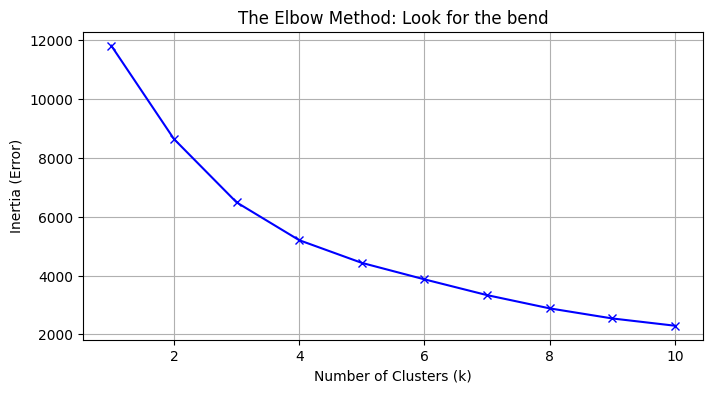

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Select the numeric columns for clustering
# We combine the raw SQL output with the features we want to analyze
# Note: We DROP 'ID#' because it's just a label, not a behavior
features_to_cluster = ['Balance', 'Miles_Per_Bonus_Transaction', 'Overall_Engagement_Score']

X = sql_df[features_to_cluster]

# 2. SCALE THE DATA
# This forces all columns to have Mean=0 and Variance=1
# Critical because 'Balance' (100,000) would otherwise drown out 'Engagement' (50)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. The Elbow Method (Finding 'k')
inertia = []
range_values = range(1, 11)

for i in range_values:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 4. Plot the Curve
plt.figure(figsize=(8, 4))
plt.plot(range_values, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Error)')
plt.title('The Elbow Method: Look for the bend')
plt.grid(True)
plt.show()

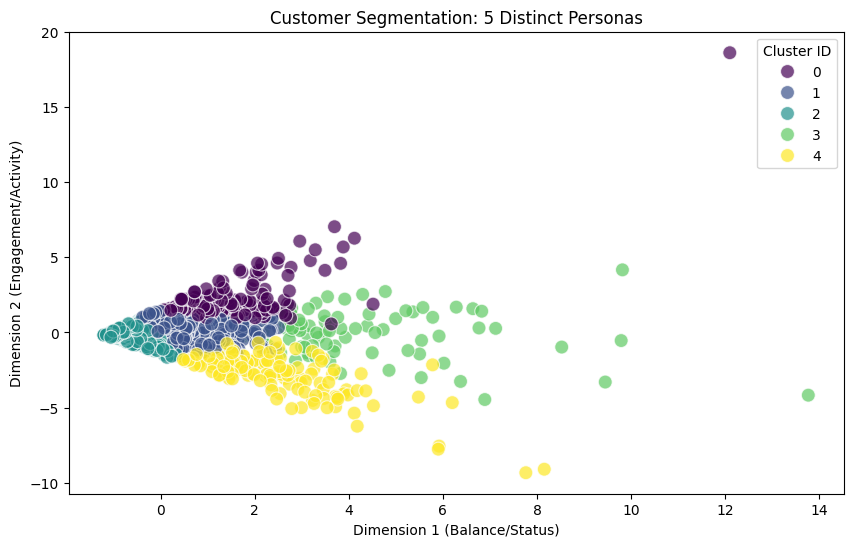

--- Customer Persona Profiles (Averages) ---
               Balance  Miles_Per_Bonus_Transaction  Overall_Engagement_Score
Cluster                                                                      
0        101332.934010                  5443.197970                 16.634518
1        109251.613086                  1892.348142                 27.548465
2         31890.732717                   432.471598                 13.274769
3        537089.164835                  2551.582418                 66.230769
4        124709.266187                   996.942446                198.525180


In [7]:
from sklearn.decomposition import PCA
import seaborn as sns

# --- STEP 4: RUN THE MODEL (With k=5) ---
# We chose 5 based on your observation of the Elbow Plot
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Assign the "Cluster Label" back to the original dataframe
# Now every customer has a group number (0-4)
sql_df['Cluster'] = kmeans.labels_

# --- STEP 5: VISUALIZE (The "Blobs") ---
# We use PCA to squash our multi-dimensional data into X and Y coordinates for plotting
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a temporary dataframe just for plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = sql_df['Cluster']

# Plot it
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segmentation: 5 Distinct Personas')
plt.xlabel('Dimension 1 (Balance/Status)')
plt.ylabel('Dimension 2 (Engagement/Activity)')
plt.legend(title='Cluster ID')
plt.show()

# --- THE BUSINESS INSIGHT --
# This table tells you the story. Look for the extremes (Highest Balance, Lowest Score, etc.)
print("--- Customer Persona Profiles (Averages) ---")
profile = sql_df.groupby('Cluster')[['Balance', 'Miles_Per_Bonus_Transaction', 'Overall_Engagement_Score']].mean()
print(profile)

# Cluster Inisghts

0. "The Points Hackers"	Monitor. They have high balances (100k) but barely engage (Score 16). They are likely gaming the credit card bonuses. Don't waste marketing budget here.
1. "The Passive Savers"	Nudge. They have points but aren't using them. Send a "Use your miles for a tropical vacation" email to reduce liability.
2. "The Low-Value / Newbies"	Ignore or Automate. They are the majority (usually) but bring the least value. Only send automated low-cost emails. 
3. "The VIP Whales"	Do Not Disturb. These are your top 1%. They are rich and happy. Just send them a holiday gift.  
4. "The Road Warriors"	Upsell. They are constantly flying/interacting but have lower balances than Whales. Offer them a credit card upgrade to capture more value.   